In [31]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [11]:
red=pd.read_csv('winequality-red.csv',sep=';')
red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Statistical Method Outlier Detect - Interquartile Ranges & Outliers

In [134]:
# Dectecting outliers which are defined as outside of lower and upper whisker in the box plot
from collections import Counter


# outliers funtion: 
# df is the input data set
# variables are targeted features or column names
# n is number of features with potential outliers in each observation. eg. if n = 1, 
#             then the outliers are the rows with more than 1 features have outter trange values

def outliers(df, variables, n):
    outlier_indices = []
    for col in variables:
        upper = np.percentile(df[col], 75)
        lower = np.percentile(df[col], 25)
        IQR = upper - lower
        
        # Define outliers are outside of 1.5 IQR
        outliers_temp = (df[(df[col] < lower - IQR * 1.5)|(df[col] > upper + IQR * 1.5)] ).index
        outlier_indices.extend(outliers_temp)
        
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return(multiple_outliers)   

col_list = list(red.columns.values)

# return index list of outliers
Outliers_to_drop = outliers(red, col_list, 1)


## Machine Learning Outlier Detect - DBSCAN

In [40]:
import math
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Treat data set as an unlabeled data set and impliment the DBSCAN to detect outliers
y = red.iloc[:,-1].values
X = red.iloc[:, :-1].values

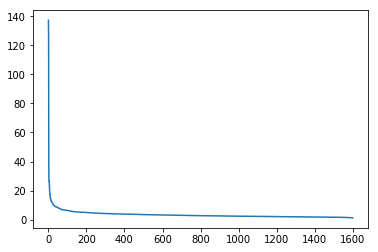

In [129]:

# determine the minimum number of reachable sample
min_sample = round(math.log(len(X)))

nbrs = NearestNeighbors(n_neighbors=min_sample).fit(X)
distances, indices = nbrs.kneighbors(X)
distanceDec = sorted(distances[:,-1], reverse=True)
knn_plot = plt.plot(list(range(1,len(X)+1)), distanceDec)


In [101]:
# DBSCAN method

# From the plot, the turnning point is around 10, so set the spslion is 10.
epslion = 10
dbsc = DBSCAN(eps = epslion, min_samples = min_sample).fit(X)
# Get the labels
labels = dbsc.labels_
# Identify the core points
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True


In [136]:
# Check if there are two classses. The minor class suppouse to be outliers

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
print(unique_labels)

# outlier s
outliers = np.where(labels == -1)
outliers = np.array(outliers).tolist()
outliers = outliers[0]

[-1  0]


Text(0,0.5,'Y')

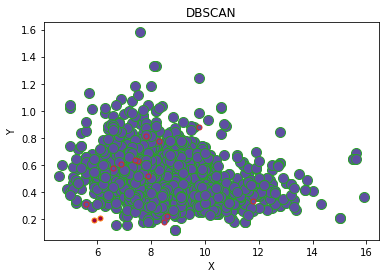

In [133]:
# Generate the plot

for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = X[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = X[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
        
plt.title("DBSCAN")
plt.xlabel("X")
plt.ylabel("Y")

In [139]:
outlier_list = set(Outliers_to_drop) & set(outliers)
